<a href="https://colab.research.google.com/github/SimoneRosset/AUGMENTATION_GAN/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AUGMENTATION_GAN
based on this [paper](https://arxiv.org/pdf/1803.01229.pdf)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

In [2]:
import os
from tqdm import notebook
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate
import gc
import datetime as dt

In [3]:
# gc.collect()
# torch.cuda.empty_cache()
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [4]:
from google.colab import drive
drive.mount('/content/drive') 
%cd /content/drive/My\ Drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [6]:
# !git clone https://github.com/vj2050/Transfer-Learning-COVID-19.git

# data_dir_='Transfer-Learning-COVID-19/dataset_4_classes/'


In [7]:
# train_loader = torch.utils.data.DataLoader(
#              torch.utils.data.ConcatDataset([
#                  torchvision.datasets.ImageFolder(os.path.join(
#           data_dir, "train/"), transform=transform),
#                  torchvision.datasets.ImageFolder(os.path.join(
#           data_dir, "test/"), transform=transform)]
#              ),
#              batch_size=64,
#              num_workers=2, shuffle=True)

In [8]:
# print(len(train_loader.dataset))

In [58]:
img_dim=64
N_rot=3
N_flip=5
N_tran=7
N_scal=3
transform_list=[]

transform_list.append(transforms.Grayscale(num_output_channels=1))

transform_list.append(transforms.Resize((img_dim*2,img_dim*2),interpolation=2))

for i in range(N_rot):
  transform_list.append(transforms.RandomApply([transforms.RandomRotation(degrees=(-90,90))], p=0.5))
for i in range(N_flip):
  transform_list.append(transforms.RandomHorizontalFlip(p=0.5))
for i in range(N_flip):
  transform_list.append(transforms.RandomVerticalFlip(p=0.5))
for i in range(N_scal):
  transform_list.append(transforms.RandomApply([transforms.RandomAffine(degrees=0,scale=(0.9,1.1))], p=0.5))
for i in range(N_tran):
  transform_list.append(transforms.RandomApply([transforms.RandomAffine(degrees=0,translate=(0.1,0.1))], p=0.5))

transform_list.append(transforms.Resize((img_dim,img_dim),interpolation=2))

transform_list.append(transforms.ToTensor())

transform_list.append(transforms.Normalize((0.5), (0.5)))

transform_ = transforms.Compose(transform_list)

# transform = transforms.Compose([transforms.ToTensor(),
#                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [122]:
batch_size_train=64
batch_size_test=36
num_samples=batch_size_train*8
img_dim=64

#data_dir = 'custom_covid_dataset/classic_augment/3_classes'
data_dir = 'custom_covid_dataset/classic_augment/4_classes'
data_dir_gan = 'custom_covid_dataset/gan_augment/4_classes'

# transform = transforms.Compose([transforms.ToTensor(),
#                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])

transform_resize = transforms.Compose([transforms.Resize((img_dim,img_dim)),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])


trainset0 = torchvision.datasets.ImageFolder(os.path.join(
          data_dir, "0/"), transform=transform)
# trainset500 = torchvision.datasets.ImageFolder(os.path.join(
#           data_dir, "500/"), transform=transform)
# trainset1000 = torchvision.datasets.ImageFolder(os.path.join(
#           data_dir, "1000/"), transform=transform)
# trainset2000 = torchvision.datasets.ImageFolder(os.path.join(
#           data_dir, "2000/"), transform=transform)

trainset100_gan = torchvision.datasets.ImageFolder(os.path.join(
          data_dir_gan, "100/"), transform=transform)
trainset500_gan = torchvision.datasets.ImageFolder(os.path.join(
          data_dir_gan, "500/"), transform=transform)
trainset1000_gan = torchvision.datasets.ImageFolder(os.path.join(
          data_dir_gan, "1000/"), transform=transform)
trainset2000_gan = torchvision.datasets.ImageFolder(os.path.join(
          data_dir_gan, "2000/"), transform=transform)


listtrainset = [trainset0,trainset100_gan,trainset500_gan,trainset1000_gan,trainset2000_gan]

trainset_concat = torch.utils.data.ConcatDataset(listtrainset)

#sampler = torch.utils.data.RandomSampler(trainset_concat,replacement=True, num_samples=num_samples)

trainloader = torch.utils.data.DataLoader(trainset_concat, shuffle=True, # sampler=sampler, 
                                          batch_size=batch_size_train)

testset0 = torchvision.datasets.ImageFolder(os.path.join( 
          data_dir, "test/"), transform=transform)
# testset40 = torchvision.datasets.ImageFolder(os.path.join( 
#           'custom_covid_dataset/', "more_covid_samples/"), transform=transform_resize)
listtestset = [testset0]
testloader = torch.utils.data.DataLoader(
          torch.utils.data.ConcatDataset(listtestset), batch_size=batch_size_test, shuffle=False)

classes = ("covid", "normal", "pneumonia_bac", "pneumonia_vir")

In [123]:
print(len(trainloader.dataset))

8270


In [124]:
print(len(testloader.dataset))

36


In [125]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    img_=np.transpose(npimg, (1, 2, 0))
    if img_.shape[2]==1:
      img_=img_[:,:,0]
    plt.imshow(img_)
    plt.show()


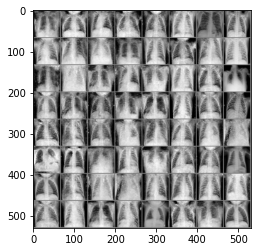

covid normal pneumonia_bac normal normal pneumonia_vir covid normal pneumonia_bac pneumonia_vir pneumonia_bac covid pneumonia_vir normal pneumonia_vir pneumonia_vir covid pneumonia_bac covid pneumonia_bac covid pneumonia_vir normal covid normal covid normal covid covid pneumonia_vir normal normal normal pneumonia_vir normal pneumonia_bac pneumonia_vir normal pneumonia_bac pneumonia_bac covid normal covid pneumonia_vir covid normal normal pneumonia_vir normal pneumonia_vir pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_vir pneumonia_bac pneumonia_bac normal pneumonia_vir covid pneumonia_bac pneumonia_bac normal covid normal


In [96]:
# get some random training images
dataiter = iter(trainloader)
images_train, labels_train = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images_train))
# print labels
print(' '.join('%5s' % classes[labels_train[j]] for j in range(batch_size_train)))

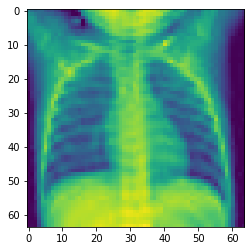

normal


In [97]:
rnd = np.random.randint(0,batch_size_train)
imshow(images_train[rnd])
print(classes[labels_train[rnd]])

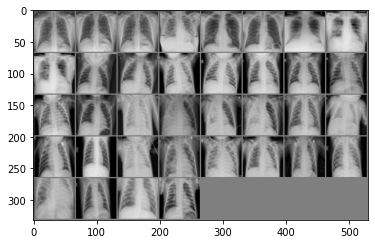

GroundTruth:  covid covid covid covid covid covid covid covid covid normal normal normal normal normal normal normal normal normal pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir


In [98]:
dataiter = iter(testloader)
images_test, labels_test = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(batch_size_test)))

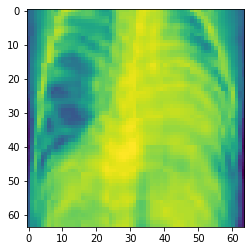

pneumonia_vir


In [99]:
rnd = np.random.randint(0,batch_size_test)
imshow(images_test[rnd])
print(classes[labels_test[rnd]])

In [117]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):

    def _name(self):
        return "CNN"

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )

    def _build_models(self):
        self.conv1 = nn.Sequential(
            self._conv2d(self.channels_size, self.hidden_size),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            self._conv2d(self.hidden_size , self.hidden_size * 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size * 2),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size*2, self.hidden_size * 4),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size * 4),
            nn.MaxPool2d(2, 2)
        )
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(int(self.hidden_size * 4 * img_dim/8 * img_dim/8), img_dim*4),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(img_dim*4, class_number),
            nn.Softmax(dim=1)
        )
        return self.conv1, self.conv2, self.conv3, self.dense

    def __init__(self, hidden_size, channels_size, class_number):
        super().__init__()
        self.hidden_size = hidden_size
        self.channels_size = channels_size
        self.class_number = class_number
        self._models = self._build_models()
        self.name = self._name()

    def forward(self, image):
        x = self._models[0](image)
        x_1 = self._models[1](x)
        x_2 = self._models[2](x_1)
        x_3 = self._models[3](x_2)
        return x_3

In [127]:
hidden_size=32
channels_size=1
class_number=4

net=CNN(hidden_size, channels_size, class_number)

In [128]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [129]:
epochs=150

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

net.to(device)

summary(net, (channels_size, img_dim, img_dim))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
              ReLU-2           [-1, 32, 64, 64]               0
       BatchNorm2d-3           [-1, 32, 64, 64]              64
         MaxPool2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,496
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
             ReLU-10          [-1, 128, 16, 16]               0
      BatchNorm2d-11          [-1, 128, 16, 16]             256
        MaxPool2d-12            [-1, 128, 8, 8]               0
          Flatten-13                 [-1, 8192]               0
           Linear-14            


Epoch: [1]  => Loss: [0.751]



Epoch: [2]  => Loss: [0.751]



Epoch: [3]  => Loss: [0.750]



Epoch: [4]  => Loss: [0.750]



Epoch: [5]  => Loss: [0.749]



Epoch: [6]  => Loss: [0.749]



Epoch: [7]  => Loss: [0.749]



Epoch: [8]  => Loss: [0.749]



Epoch: [9]  => Loss: [0.748]



Epoch: [10]  => Loss: [0.748]



Epoch: [10]  => Test: [1]  => Loss: [1.072]
Epoch: [10]  => Confusion Matrix Test: [1]  => Total Accuracy: [0.639]


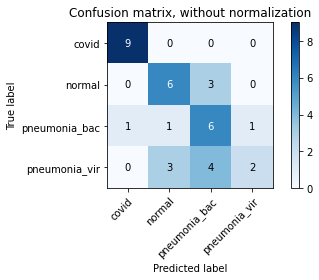

Epoch: [10]  => Evaluation Confusion Matrix Test: [1]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   0.972222 │      1        │      0.962963 │  0.985915 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.805556 │      0.666667 │      0.851852 │  0.72956  │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.722222 │      0.666667 │      0.740741 │  0.693333 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │   0.777778 │      0.222222 │      0.962963 │  0.345679 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [11]  => Loss: [0.748]



Epoch: [12]  => Loss: [0.748]



Epoch: [13]  => Loss: [0.747]



Epoch: [14]  => Loss: [0.748]



Epoch: [15]  => Loss: [0.747]



Epoch: [16]  => Loss: [0.747]



Epoch: [17]  => Loss: [0.747]



Epoch: [18]  => Loss: [0.746]



Epoch: [19]  => Loss: [0.746]



Epoch: [20]  => Loss: [0.746]



Epoch: [20]  => Test: [2]  => Loss: [1.088]
Epoch: [20]  => Confusion Matrix Test: [2]  => Total Accuracy: [0.639]


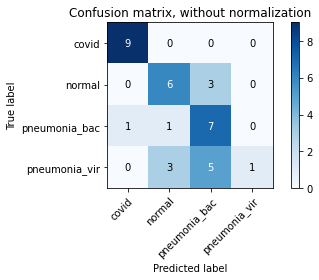

Epoch: [20]  => Evaluation Confusion Matrix Test: [2]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   0.972222 │      1        │      0.962963 │  0.985915 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.805556 │      0.666667 │      0.851852 │  0.72956  │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.722222 │      0.777778 │      0.703704 │  0.748971 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │   0.777778 │      0.111111 │      1        │  0.194444 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [21]  => Loss: [0.746]



Epoch: [22]  => Loss: [0.746]



Epoch: [23]  => Loss: [0.746]



Epoch: [24]  => Loss: [0.746]



Epoch: [25]  => Loss: [0.746]



Epoch: [26]  => Loss: [0.746]



Epoch: [27]  => Loss: [0.746]



Epoch: [28]  => Loss: [0.745]



Epoch: [29]  => Loss: [0.745]



Epoch: [30]  => Loss: [0.745]



Epoch: [30]  => Test: [3]  => Loss: [1.050]
Epoch: [30]  => Confusion Matrix Test: [3]  => Total Accuracy: [0.667]


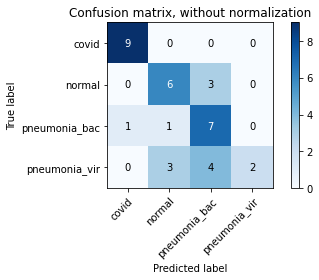

Epoch: [30]  => Evaluation Confusion Matrix Test: [3]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   0.972222 │      1        │      0.962963 │  0.985915 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.805556 │      0.666667 │      0.851852 │  0.72956  │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.75     │      0.777778 │      0.740741 │  0.763636 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │   0.805556 │      0.222222 │      1        │  0.348348 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [31]  => Loss: [0.746]



Epoch: [32]  => Loss: [0.745]



Epoch: [33]  => Loss: [0.745]



Epoch: [34]  => Loss: [0.745]



Epoch: [35]  => Loss: [0.745]



Epoch: [36]  => Loss: [0.745]



Epoch: [37]  => Loss: [0.745]



Epoch: [38]  => Loss: [0.745]



Epoch: [39]  => Loss: [0.745]



Epoch: [40]  => Loss: [0.745]



Epoch: [40]  => Test: [4]  => Loss: [1.061]
Epoch: [40]  => Confusion Matrix Test: [4]  => Total Accuracy: [0.667]


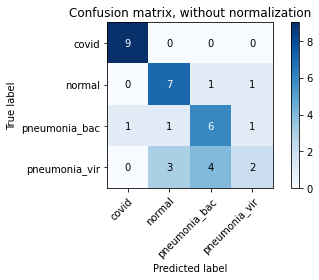

Epoch: [40]  => Evaluation Confusion Matrix Test: [4]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   0.972222 │      1        │      0.962963 │  0.985915 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.833333 │      0.777778 │      0.851852 │  0.804598 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.777778 │      0.666667 │      0.814815 │  0.717949 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │   0.75     │      0.222222 │      0.925926 │  0.342857 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [41]  => Loss: [0.745]



Epoch: [42]  => Loss: [0.745]



Epoch: [43]  => Loss: [0.744]



Epoch: [44]  => Loss: [0.744]



Epoch: [45]  => Loss: [0.745]



Epoch: [46]  => Loss: [0.744]



Epoch: [47]  => Loss: [0.744]



Epoch: [48]  => Loss: [0.744]



Epoch: [49]  => Loss: [0.744]



Epoch: [50]  => Loss: [0.744]



Epoch: [50]  => Test: [5]  => Loss: [1.043]
Epoch: [50]  => Confusion Matrix Test: [5]  => Total Accuracy: [0.694]


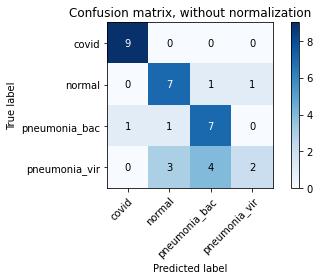

Epoch: [50]  => Evaluation Confusion Matrix Test: [5]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   0.972222 │      1        │      0.962963 │  0.985915 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.833333 │      0.777778 │      0.851852 │  0.804598 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.805556 │      0.777778 │      0.814815 │  0.791423 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │   0.777778 │      0.222222 │      0.962963 │  0.345679 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [51]  => Loss: [0.744]



Epoch: [52]  => Loss: [0.744]



Epoch: [53]  => Loss: [0.744]



Epoch: [54]  => Loss: [0.744]



Epoch: [55]  => Loss: [0.744]



Epoch: [56]  => Loss: [0.744]



Epoch: [57]  => Loss: [0.744]



Epoch: [58]  => Loss: [0.744]



Epoch: [59]  => Loss: [0.744]



Epoch: [60]  => Loss: [0.744]



Epoch: [60]  => Test: [6]  => Loss: [1.059]
Epoch: [60]  => Confusion Matrix Test: [6]  => Total Accuracy: [0.694]


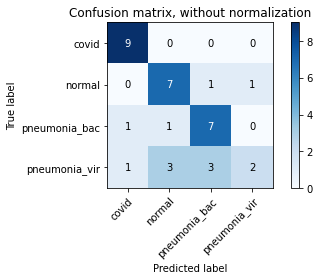

Epoch: [60]  => Evaluation Confusion Matrix Test: [6]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   0.944444 │      1        │      0.925926 │  0.971429 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.833333 │      0.777778 │      0.851852 │  0.804598 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.833333 │      0.777778 │      0.851852 │  0.804598 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │   0.777778 │      0.222222 │      0.962963 │  0.345679 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [61]  => Loss: [0.744]



Epoch: [62]  => Loss: [0.744]



Epoch: [63]  => Loss: [0.744]



Epoch: [64]  => Loss: [0.744]



Epoch: [65]  => Loss: [0.744]


In [ ]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for data in notebook.tqdm(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        
        gc.collect()
        if torch.cuda.is_available():
            inputs, labels = data[0].cuda(), data[1].cuda()  
        else:
            inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print("Epoch: [%d]"%(epoch + 1),' => Loss: [%.3f]' %(running_loss / len(trainloader)))
    running_loss = 0.0
    if (epoch+1)%10==0:
        running_loss_=0
        with torch.no_grad():
            for data in notebook.tqdm(testloader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data[0].to(device), data[1].to(device)

                outputs = net(inputs)

                _, predicted = torch.max(outputs, 1)

                loss = criterion(outputs, labels)

                running_loss_ += loss.item()

                cm = confusion_matrix(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), labels=None, sample_weight=None)
                
                tot_acc=np.trace(cm)/np.sum(cm)

                sensitivity = list(0. for i in range(cm.shape[0]))
                specificity = list(0. for i in range(cm.shape[0]))
                accuracy = list(0. for i in range(cm.shape[0]))
                f1score = list(0. for i in range(cm.shape[0]))
                table = list(0. for i in range(cm.shape[0]))

                for i in range(cm.shape[0]):
                    TP = cm[i,i]
                    FN = np.sum(cm[i,:]) - TP
                    FP = np.sum(cm[:,i]) - TP
                    TN = (np.sum(cm) - TP - FP - FN)
                    accuracy[i] = (TP + TN) / (TP + TN + FP + FN) 
                    sensitivity[i] = TP / (TP + FN) 
                    specificity[i] = TN / (TN + FP) 
                    f1score[i]= 2 * (accuracy[i] * sensitivity[i]) / (accuracy[i] + sensitivity[i])
                    table[i]=[classes[i], accuracy[i], sensitivity[i], specificity[i], f1score[i]]
            
            print("Epoch: [%d]"%(epoch + 1)," => Test: [%d]" %(int((epoch+1)/10)),' => Loss: [%.3f]' %(running_loss_ / len(testloader)))
            
            print("Epoch: [%d]"%(epoch + 1)," => Confusion Matrix Test: [%d]" %(int((epoch+1)/10))," => Total Accuracy: [%.3f]" %(tot_acc))

            plot_confusion_matrix(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), classes=np.asarray(classes), normalize=False)

            plt.show()

            print("Epoch: [%d]"%(epoch + 1)," => Evaluation Confusion Matrix Test: [%d]" %(int((epoch+1)/10)))

            print(tabulate(table, headers=['Accuracy','Sensitivity', 'Specificity', 'F1Score'], tablefmt='fancy_grid'))

print('Finished Training')
PATH = './CNN_CLASSIC_'+str(channels_size)+'c_D'+str(len(listtrainset))+'_{}.pth'.format(dt.datetime.now())
torch.save(net.state_dict(), PATH)

In [ ]:
# net.load_state_dict(torch.load(PATH))
# net.eval()

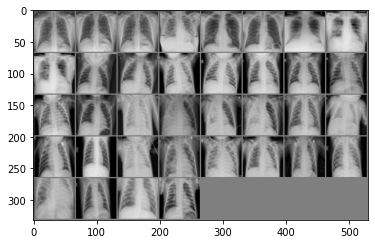

GroundTruth:  covid covid covid covid covid covid covid covid covid normal normal normal normal normal normal normal normal normal pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir


In [85]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size_test)))

In [86]:
outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch_size_test)))

Predicted:  covid covid covid covid covid covid covid covid covid pneumonia_bac normal normal normal normal normal pneumonia_bac normal normal pneumonia_vir pneumonia_bac pneumonia_bac pneumonia_vir pneumonia_vir pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_vir pneumonia_bac normal pneumonia_vir pneumonia_bac pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir normal


In [87]:
print(classification_report(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), labels=None, target_names=classes, digits=3))

               precision    recall  f1-score   support

        covid      1.000     1.000     1.000         9
       normal      0.778     0.778     0.778         9
pneumonia_bac      0.556     0.556     0.556         9
pneumonia_vir      0.556     0.556     0.556         9

     accuracy                          0.722        36
    macro avg      0.722     0.722     0.722        36
 weighted avg      0.722     0.722     0.722        36



[[9 0 0 0]
 [0 7 2 0]
 [0 0 5 4]
 [0 2 2 5]]


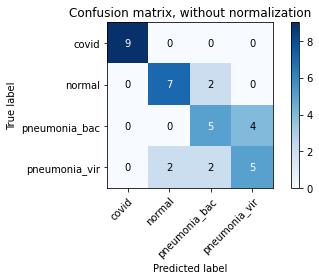

In [88]:
cm = confusion_matrix(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), labels=None, sample_weight=None)

print(cm)

plot_confusion_matrix(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), classes=np.asarray(classes), normalize=False)

Reference to estimated values

<img src="https://devopedia.org/images/article/208/6541.1566280388.jpg" alt="Drawing" width= '400px'/>


In [89]:
tot_acc=np.trace(cm)/np.sum(cm)

sensitivity = list(0. for i in range(cm.shape[0]))
specificity = list(0. for i in range(cm.shape[0]))

for i in range(cm.shape[0]):
  TP = cm[i,i]
  FN = np.sum(cm[i,:]) - cm[i,i]
  TN = (np.sum(cm)-np.sum(cm[i,:])-np.sum(cm[:,i]))
  FP = np.sum(cm[:,i]) - cm[i,i]
  sensitivity[i]= TP/ (TP + FN) 
  specificity[i]= TN /(TN + FP) 
  print("sensitivity for class ",classes[i],": ", sensitivity[i].round(3)) # probability of a positive test given that the patient has the disease
  print("specificity for class ",classes[i],": ", specificity[i].round(3)) # the percentage of healthy people who are correctly identified as not having the condition

# print("total sensitivity: ", (np.sum(sensitivity)/len(classes)).round(3)) # needed?
# print("total specificity: ", (np.sum(specificity)/len(classes)).round(3)) # needed?
print("tot_acc: ",tot_acc.round(3))


sensitivity for class  covid :  1.0
specificity for class  covid :  1.0
sensitivity for class  normal :  0.778
specificity for class  normal :  0.9
sensitivity for class  pneumonia_bac :  0.556
specificity for class  pneumonia_bac :  0.818
sensitivity for class  pneumonia_vir :  0.556
specificity for class  pneumonia_vir :  0.818
tot_acc:  0.722


In [90]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (
    100 * correct / total))

Accuracy: 80 %


In [91]:
class_correct = list(0. for i in range(len(classes))) #classes
class_total = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size_test): #batch
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of covid : 100 %
Accuracy of normal : 88 %
Accuracy of pneumonia_bac : 77 %
Accuracy of pneumonia_vir : 66 %
